In [8]:

from yahooquery import Ticker
import pandas as pd
import warnings

warnings.simplefilter("ignore", FutureWarning)

# Define tickers
tickers = ['IBM']

# Fetch stock data
stocks = Ticker(tickers)
data = stocks.history(start="2008-01-01", end="2024-12-31")

# Convert to DataFrame and reset index
df = pd.DataFrame(data).reset_index()

# Pivot the data to get each ticker's Close price in separate columns
df_NYSE = df.pivot(index="date", columns="symbol", values="close").reset_index()

# Display the first few rows
print("Stock price data retrieved successfully!")
print(df_NYSE.head())


Stock price data retrieved successfully!
symbol        date         IBM
0       2008-01-02  100.086044
1       2008-01-03  100.286804
2       2008-01-04   96.682602
3       2008-01-07   95.650093
4       2008-01-08   93.298279


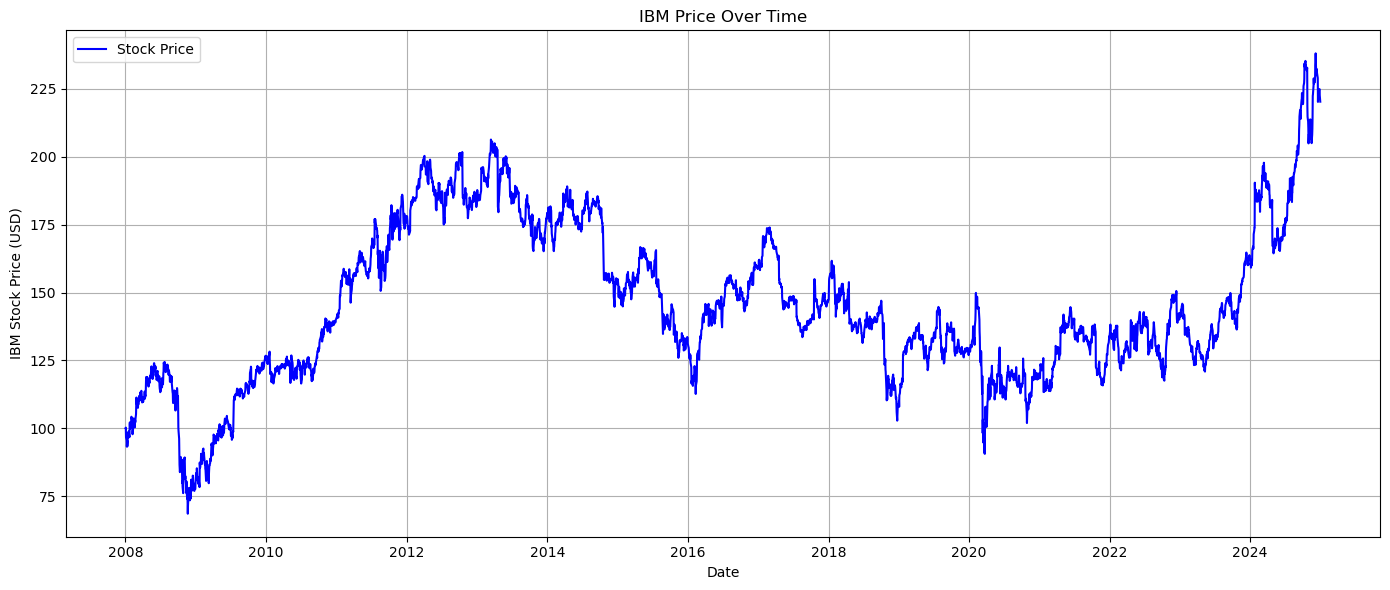

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
df_NYSE['date'] = pd.to_datetime(df_NYSE['date'])

# Sort the DataFrame by date
df_NYSE = df_NYSE.sort_values('date')

# Plot the full stock price data
plt.figure(figsize=(14, 6))
plt.plot(df_NYSE['date'], df_NYSE['IBM'], label='Stock Price', color='blue')

# Labels and title
plt.xlabel('Date')
plt.ylabel('IBM Stock Price (USD)')
plt.title('IBM Price Over Time')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


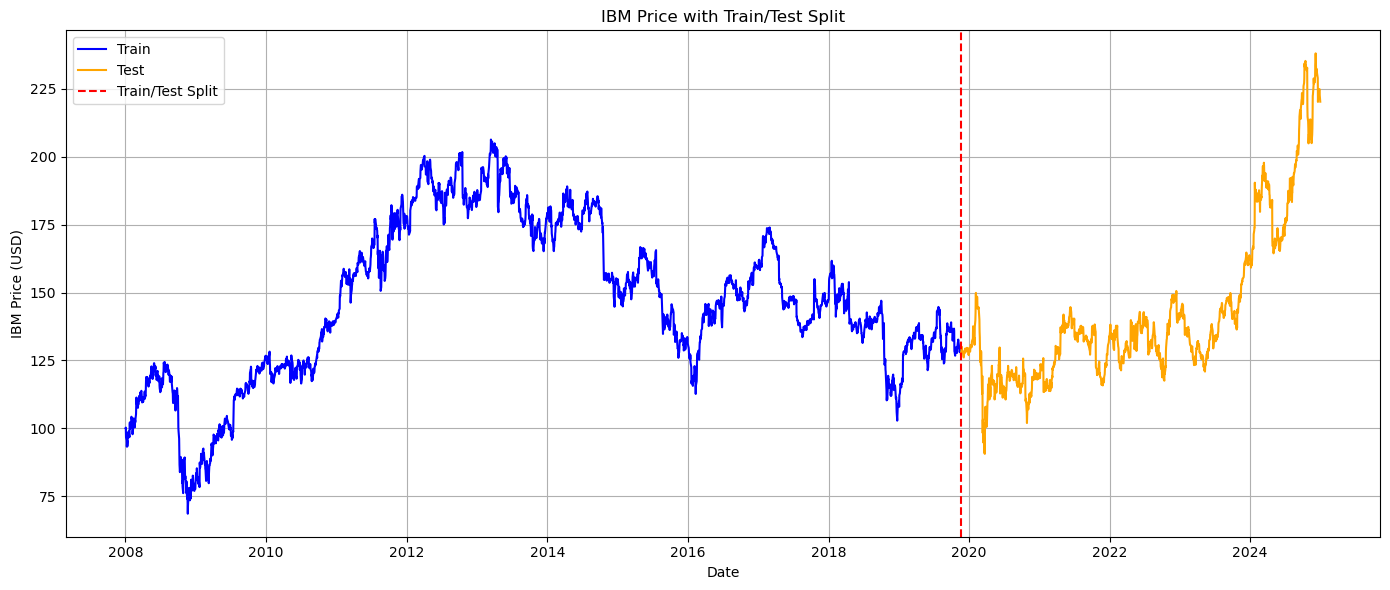

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Convert date column if not already in datetime format
df_NYSE['date'] = pd.to_datetime(df_NYSE['date'])

# Step 2: Sort by date just in case
df_NYSE = df_NYSE.sort_values('date')

# Step 3: Train-test split (70-30)
split_index = int(len(df_NYSE) * 0.7)
train_df = df_NYSE.iloc[:split_index]
test_df = df_NYSE.iloc[split_index:]

# Step 4: Plot
plt.figure(figsize=(14, 6))
plt.plot(train_df['date'], train_df['IBM'], label='Train', color='blue')
plt.plot(test_df['date'], test_df['IBM'], label='Test', color='orange')
plt.axvline(x=test_df['date'].iloc[0], color='red', linestyle='--', label='Train/Test Split')
# Labels and title
plt.xlabel('Date')
plt.ylabel('IBM Price (USD)')
plt.title('IBM Price with Train/Test Split')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Define the number of training days (70% of the dataset)
num_training_days = int(df_NYSE.shape[0] * 0.7)

# Calculate the number of test days
num_test_days = df_NYSE.shape[0] - num_training_days

# Print the result
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_test_days))

Number of training days: 2994. Number of test days: 1284.


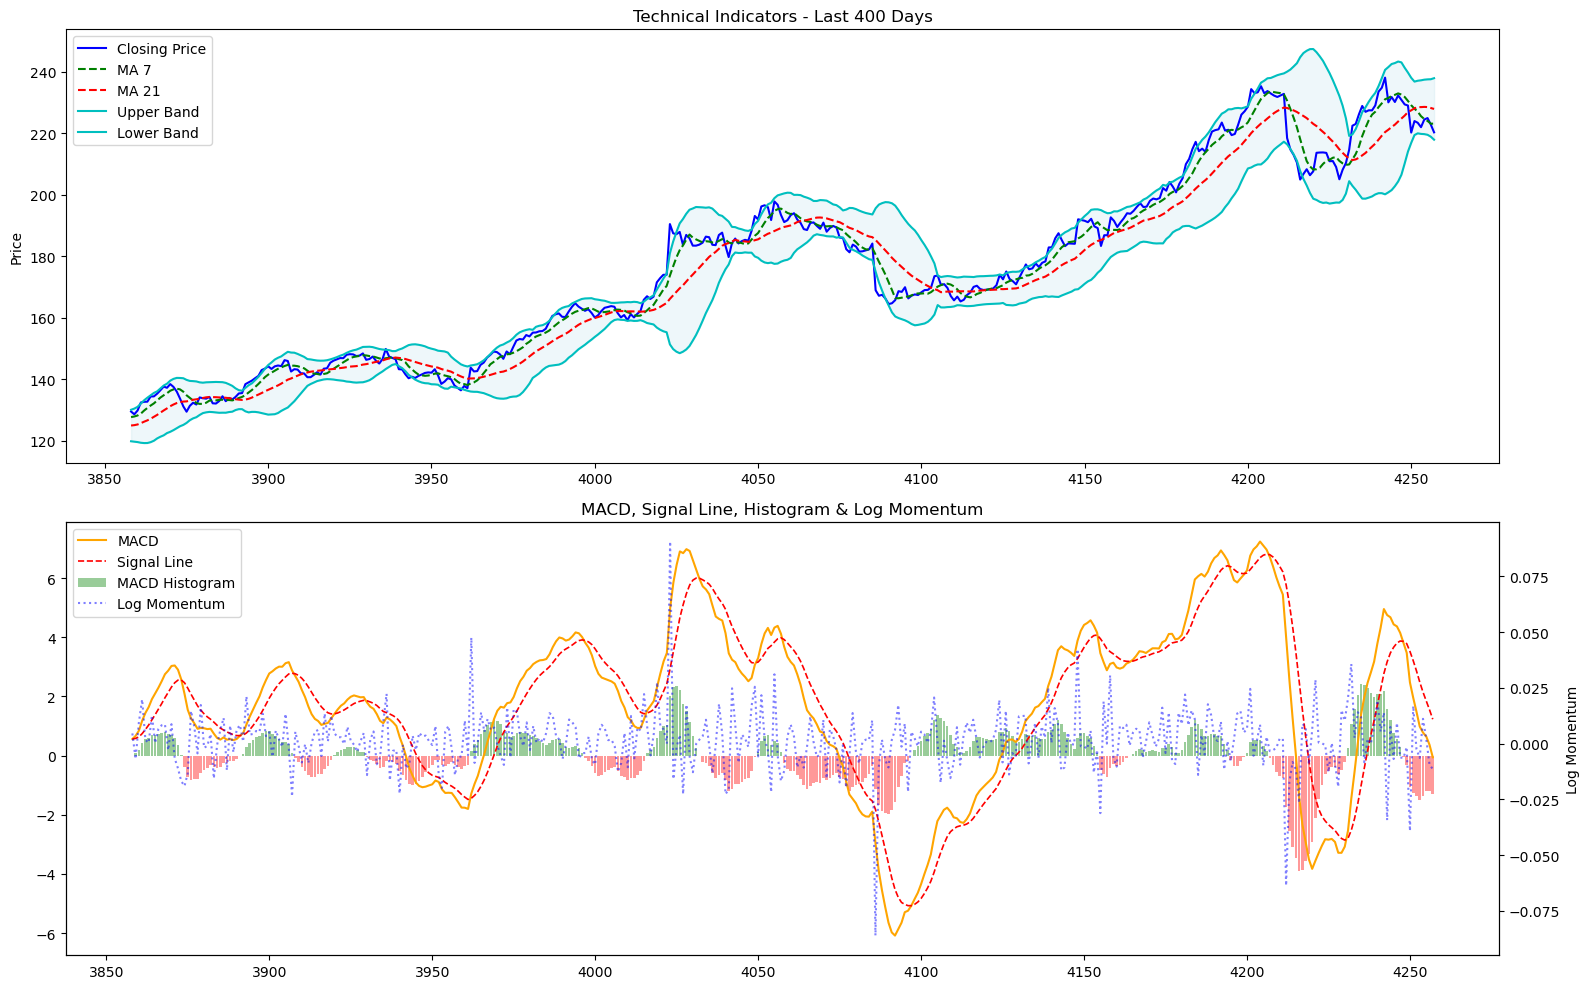

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Function to compute technical indicators
def get_technical_indicators(dataset, price_col):
    dataset['ma7'] = dataset[price_col].rolling(window=7).mean()
    dataset['ma21'] = dataset[price_col].rolling(window=21).mean()
    dataset['26ema'] = dataset[price_col].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset[price_col].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = dataset['12ema'] - dataset['26ema']
    dataset['MACD_signal'] = dataset['MACD'].ewm(span=9, adjust=False).mean()
    dataset['20sd'] = dataset[price_col].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)
    dataset['ema'] = dataset[price_col].ewm(com=0.5, adjust=False).mean()
    dataset['momentum'] = dataset[price_col] - dataset[price_col].shift(1)
    dataset['log_momentum'] = np.log(dataset[price_col] / dataset[price_col].shift(1))
    dataset = dataset.dropna().reset_index(drop=True)
    return dataset

# Apply indicators to NSE dataframe and rename price column to 'close' for consistency
df_NYSE_renamed = df_NYSE.rename(columns={"IBM": "close"})
df_NYSE_with_indicators = get_technical_indicators(df_NYSE_renamed.copy(), price_col="close")

# Step 2: Plotting function
def plot_technical_indicators(df, last_days):
    df = df.iloc[-last_days:, :].copy()
    x_ = df.index

    # Ensure Signal Line exists
    if 'Signal_Line' not in df.columns:
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    plt.figure(figsize=(16, 10), dpi=100)

    # Subplot 1: Price and Moving Averages
    plt.subplot(2, 1, 1)
    plt.plot(x_, df['close'], label='Closing Price', color='b', linewidth=1.5)
    plt.plot(x_, df['ma7'], label='MA 7', color='g', linestyle='--')
    plt.plot(x_, df['ma21'], label='MA 21', color='r', linestyle='--')
    plt.plot(x_, df['upper_band'], label='Upper Band', color='c')
    plt.plot(x_, df['lower_band'], label='Lower Band', color='c')
    plt.fill_between(x_, df['lower_band'], df['upper_band'], alpha=0.2, color='lightblue')
    plt.title(f'Technical Indicators - Last {last_days} Days')
    plt.ylabel('Price')
    plt.legend()

    # Subplot 2: MACD, Signal Line, Histogram, Log Momentum
    ax1 = plt.subplot(2, 1, 2)
    plt.title('MACD, Signal Line, Histogram & Log Momentum')
    ax1.plot(x_, df['MACD'], label='MACD', color='orange', linewidth=1.5)
    ax1.plot(x_, df['Signal_Line'], label='Signal Line', color='red', linestyle='--', linewidth=1.2)
    
    hist = df['MACD'] - df['Signal_Line']
    colors = ['green' if val >= 0 else 'red' for val in hist]
    ax1.bar(x_, hist, label='MACD Histogram', color=colors, alpha=0.4)

    ax2 = ax1.twinx()
    ax2.plot(x_, df['log_momentum'], label='Log Momentum', color='blue', linestyle=':', alpha=0.5)
    ax2.set_ylabel('Log Momentum')

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot for the last 400 days
plot_technical_indicators(df_NYSE_with_indicators, 400)



In [14]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Features and Target
features = ['ma7', 'ma21', '26ema', '12ema', 'MACD', 'MACD_signal', '20sd',
            'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum']
target_col = 'close'  # your stock price

# Select features and target
X = df_NYSE_with_indicators[features]
y = df_NYSE_with_indicators[[target_col]]  # keep it as DataFrame

# Initialize separate scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit-transform X and y separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Optional: convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=features)
y_scaled = pd.DataFrame(y_scaled, columns=['target'])



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # all columns except last (features)
        y.append(data[i, -1])                # only last column (target)
    return np.array(X), np.array(y)


# Concatenate scaled features and target
df_scaled = pd.concat([X_scaled, y_scaled], axis=1)
# Create sequences
sequence_length = 60
X, y = create_sequences(df_scaled.values, sequence_length)





Training model to 50 epochs (+50 epochs)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation after 50 epochs:
  RMSE : 2.9732
  MAE  : 2.1028
  R²   : 0.9896
  RMSPE: 0.0209

Training model to 100 epochs (+50 epochs)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation after 100 epochs:
  RMSE : 2.6392
  MAE  : 1.8299
  R²   : 0.9918
  RMSPE: 0.0192

Training model to 150 epochs (+50 epochs)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation after 150 epochs:
  RMSE : 2.8828
  MAE  : 2.1084
  R²   : 0.9902
  RMSPE: 0.0212

Training model to 200 epochs (+50 epochs)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation after 200 epochs:
  RMSE : 2.4615
  MAE  : 1.7046
  R²   : 0.9929
  RMSPE: 0.0179


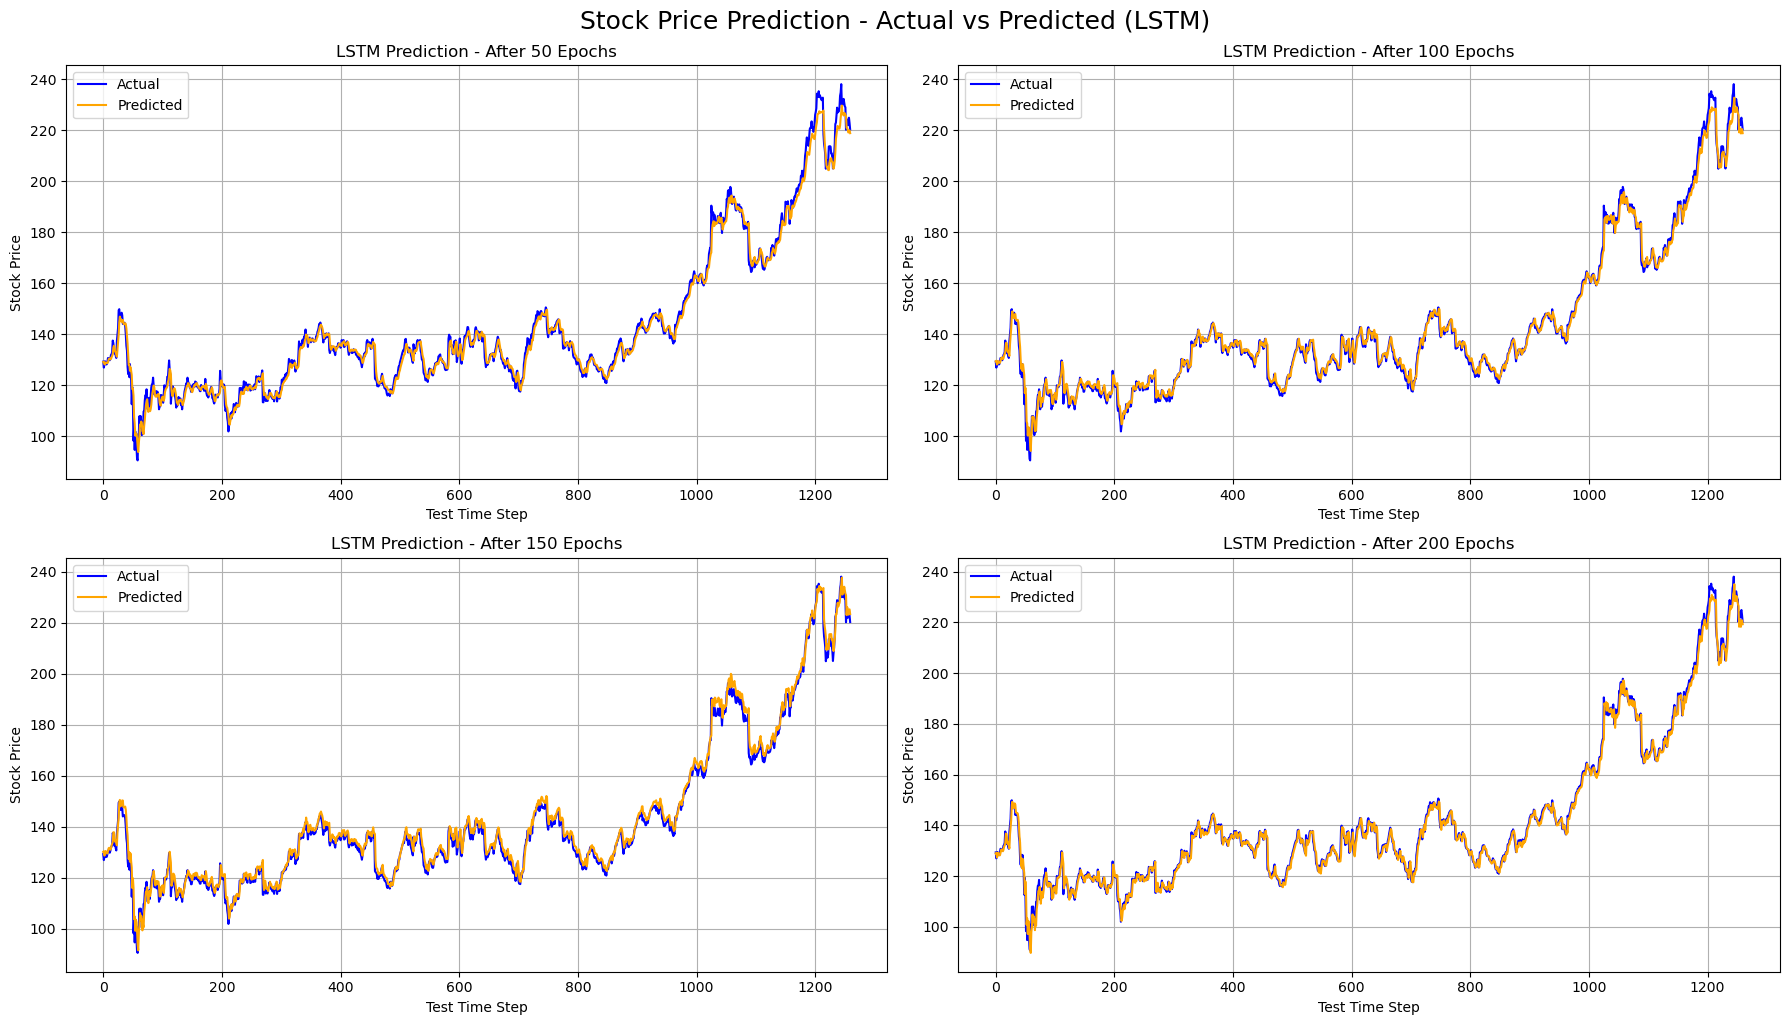

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam

# RMSPE Calculation Function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# ------------------------
# 2. Train/Test Split
# ------------------------
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # NEW: explicit Input layer
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Optimizer with learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define checkpoints for plotting after specific epochs
epochs_to_plot = [50, 100, 150, 200]  # checkpoints
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()

# Total epochs variable to track progress
total_epochs = 0

# Define scaler for inverse scaling (assumed scaler_y from previous code)
scaler = scaler_y  # Use your scaler_y for inverse scaling

# Loop over each epoch checkpoint
for i, e in enumerate(epochs_to_plot):
    if i == 0:
        epochs_now = e
    else:
        epochs_now = 50  # after first, train 50 more every time

    total_epochs += epochs_now
    print(f"\nTraining model to {total_epochs} epochs (+{epochs_now} epochs)...")

    # Continue training the model
    model.fit(X_train, y_train, epochs=epochs_now, batch_size=64, verbose=0)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse scaling for predictions and actual values
    y_test_inv = scaler.inverse_transform(
        np.concatenate([np.zeros((len(y_test), df_scaled.shape[1]-1)), y_test.reshape(-1, 1)], axis=1)
    )[:, -1]

    y_pred_inv = scaler.inverse_transform(
        np.concatenate([np.zeros((len(y_pred), df_scaled.shape[1]-1)), y_pred], axis=1)
    )[:, -1]

    # Plot Actual vs Predicted
    axs[i].plot(y_test_inv, label='Actual', color='blue')
    axs[i].plot(y_pred_inv, label='Predicted', color='orange')
    axs[i].set_title(f'LSTM Prediction - After {total_epochs} Epochs', fontsize=12)
    axs[i].set_xlabel('Test Time Step')
    axs[i].set_ylabel('Stock Price')
    axs[i].legend()
    axs[i].grid(True)

    # Metrics calculation
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    rmspe_val = rmspe(y_test_inv, y_pred_inv)  # RMSPE calculation

    print(f"Evaluation after {total_epochs} epochs:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")
    print(f"  RMSPE: {rmspe_val:.4f}")  # Output RMSPE

# ------------------------
# 5. Plot Layout
# ------------------------
plt.tight_layout()
plt.suptitle("Stock Price Prediction - Actual vs Predicted (LSTM)", fontsize=18, y=1.02)
plt.show()



Training up to 50 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Evaluation after 50 epochs:
  RMSE: 2.4537
  MAE : 1.7091
  R²  : 0.9929
  RMSPE: 0.0179

Training up to 100 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation after 100 epochs:
  RMSE: 2.7031
  MAE : 2.0144
  R²  : 0.9914
  RMSPE: 0.0201

Training up to 150 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Evaluation after 150 epochs:
  RMSE: 3.1548
  MAE : 2.1647
  R²  : 0.9883
  RMSPE: 0.0206

Training up to 200 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Evaluation after 200 epochs:
  RMSE: 3.6333
  MAE : 2.4085
  R²  : 0.9845
  RMSPE: 0.0224


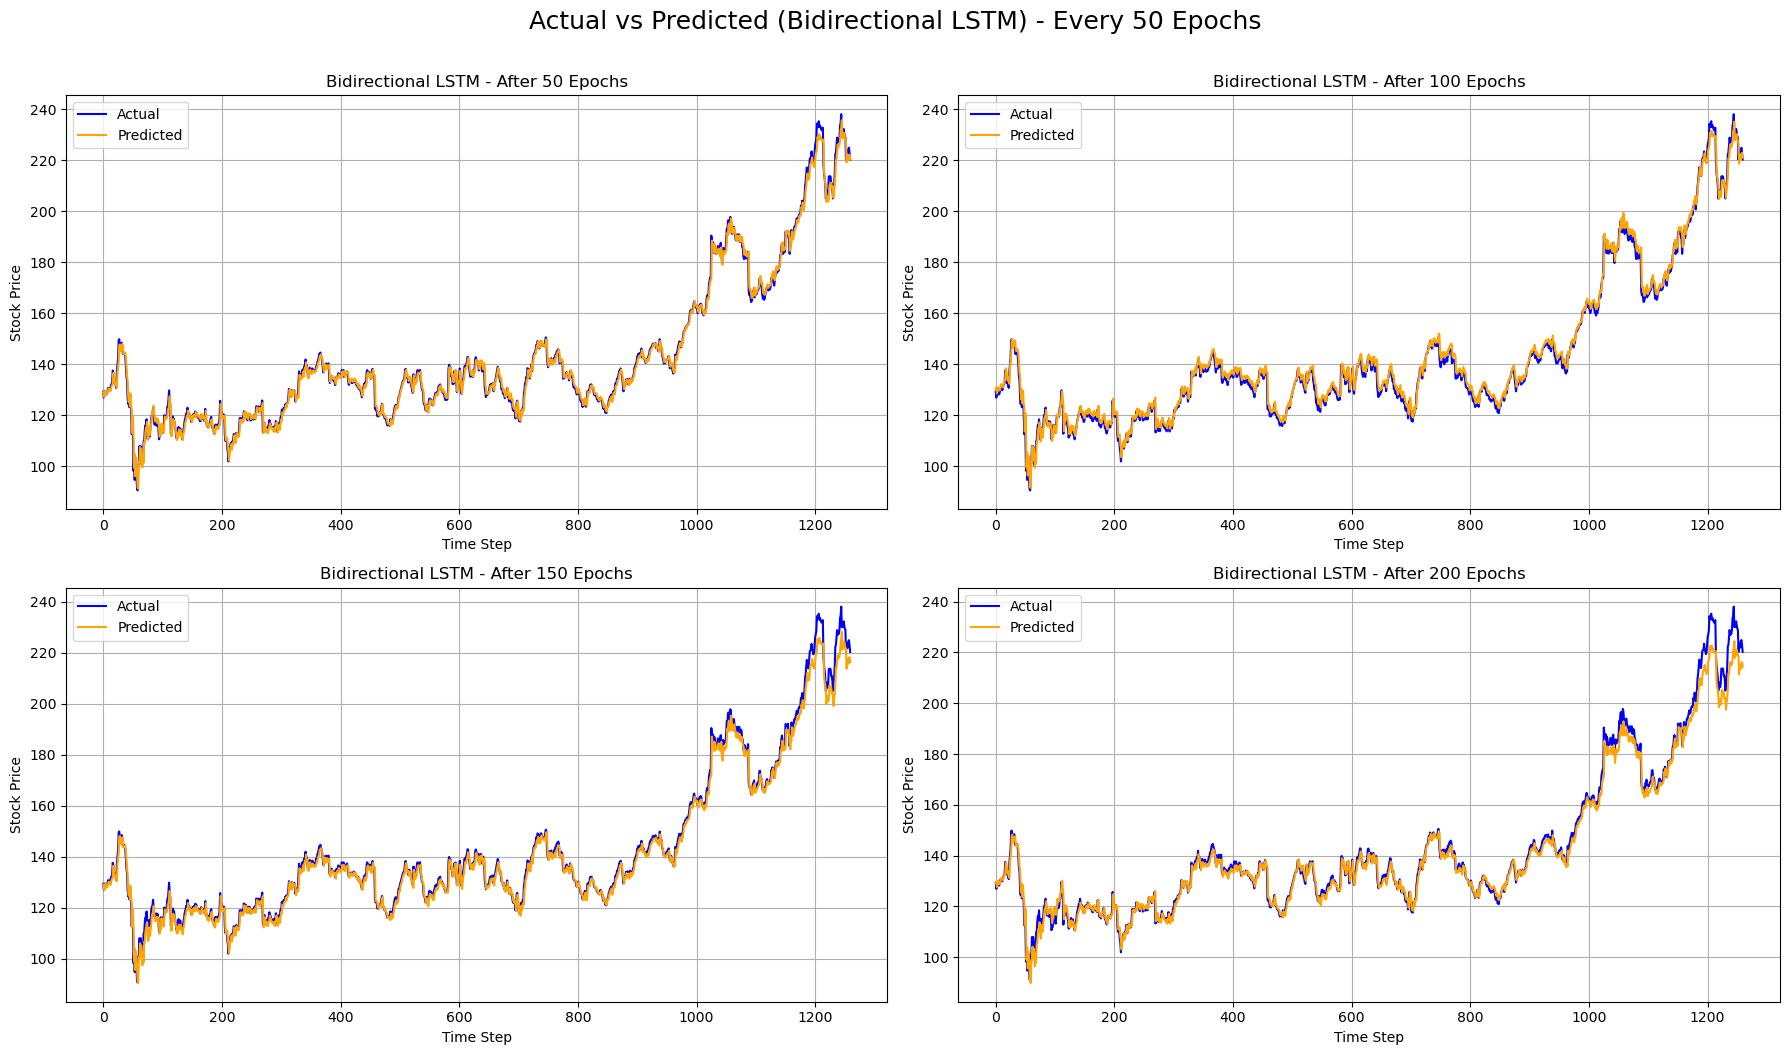

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSPE Calculation Function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# Bidirectional LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Explicit input
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(units=1)
])

# Compile with learning rate 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Epoch checkpoints and subplot setup
epochs_to_plot = [50, 100, 150, 200]
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()

# Initialize cumulative training
total_epochs = 0

# Loop over each checkpoint and continue training
for i, e in enumerate(epochs_to_plot):
    epochs_to_train = 50 if i != 0 else e  # First epoch, use the specified, others add 50
    total_epochs += epochs_to_train
    
    print(f"\nTraining up to {total_epochs} epochs...")

    # Continue training the model
    model.fit(X_train, y_train, epochs=epochs_to_train, batch_size=64, verbose=0)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse scaling (restore original scale of the target)
    zeros_test = np.zeros((y_test.shape[0], X_scaled.shape[1]))  # Adjust this with X_scaled shape
    zeros_pred = np.zeros((y_pred.shape[0], X_scaled.shape[1]))  # Adjust this with X_scaled shape

    # Inverse transform of actual and predicted values
    y_test_inv = scaler.inverse_transform(
        np.concatenate((zeros_test, y_test.reshape(-1, 1)), axis=1)
    )[:, -1]

    y_pred_inv = scaler.inverse_transform(
        np.concatenate((zeros_pred, y_pred), axis=1)
    )[:, -1]

    # Plot Actual vs Predicted
    axs[i].plot(y_test_inv, label='Actual', color='blue')
    axs[i].plot(y_pred_inv, label='Predicted', color='orange')
    axs[i].set_title(f'Bidirectional LSTM - After {total_epochs} Epochs')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Stock Price')
    axs[i].legend()
    axs[i].grid(True)

    # Metrics calculation
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    rmspe_val = rmspe(y_test_inv, y_pred_inv)  # RMSPE calculation

    print(f"Evaluation after {total_epochs} epochs:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")
    print(f"  RMSPE: {rmspe_val:.4f}")  # Output RMSPE

# Layout adjustments
plt.tight_layout()
plt.suptitle("Actual vs Predicted (Bidirectional LSTM) - Every 50 Epochs", fontsize=18, y=1.05)
plt.show()



Training GRU up to 50 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation after 50 epochs:
  RMSE: 3.0625
  MAE : 2.1622
  R²  : 0.9890
  RMSPE: 0.0199

Training GRU up to 100 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation after 100 epochs:
  RMSE: 2.7753
  MAE : 1.9557
  R²  : 0.9909
  RMSPE: 0.0197

Training GRU up to 150 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation after 150 epochs:
  RMSE: 3.1354
  MAE : 2.3201
  R²  : 0.9884
  RMSPE: 0.0211

Training GRU up to 200 epochs...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation after 200 epochs:
  RMSE: 2.4455
  MAE : 1.6831
  R²  : 0.9930
  RMSPE: 0.0179


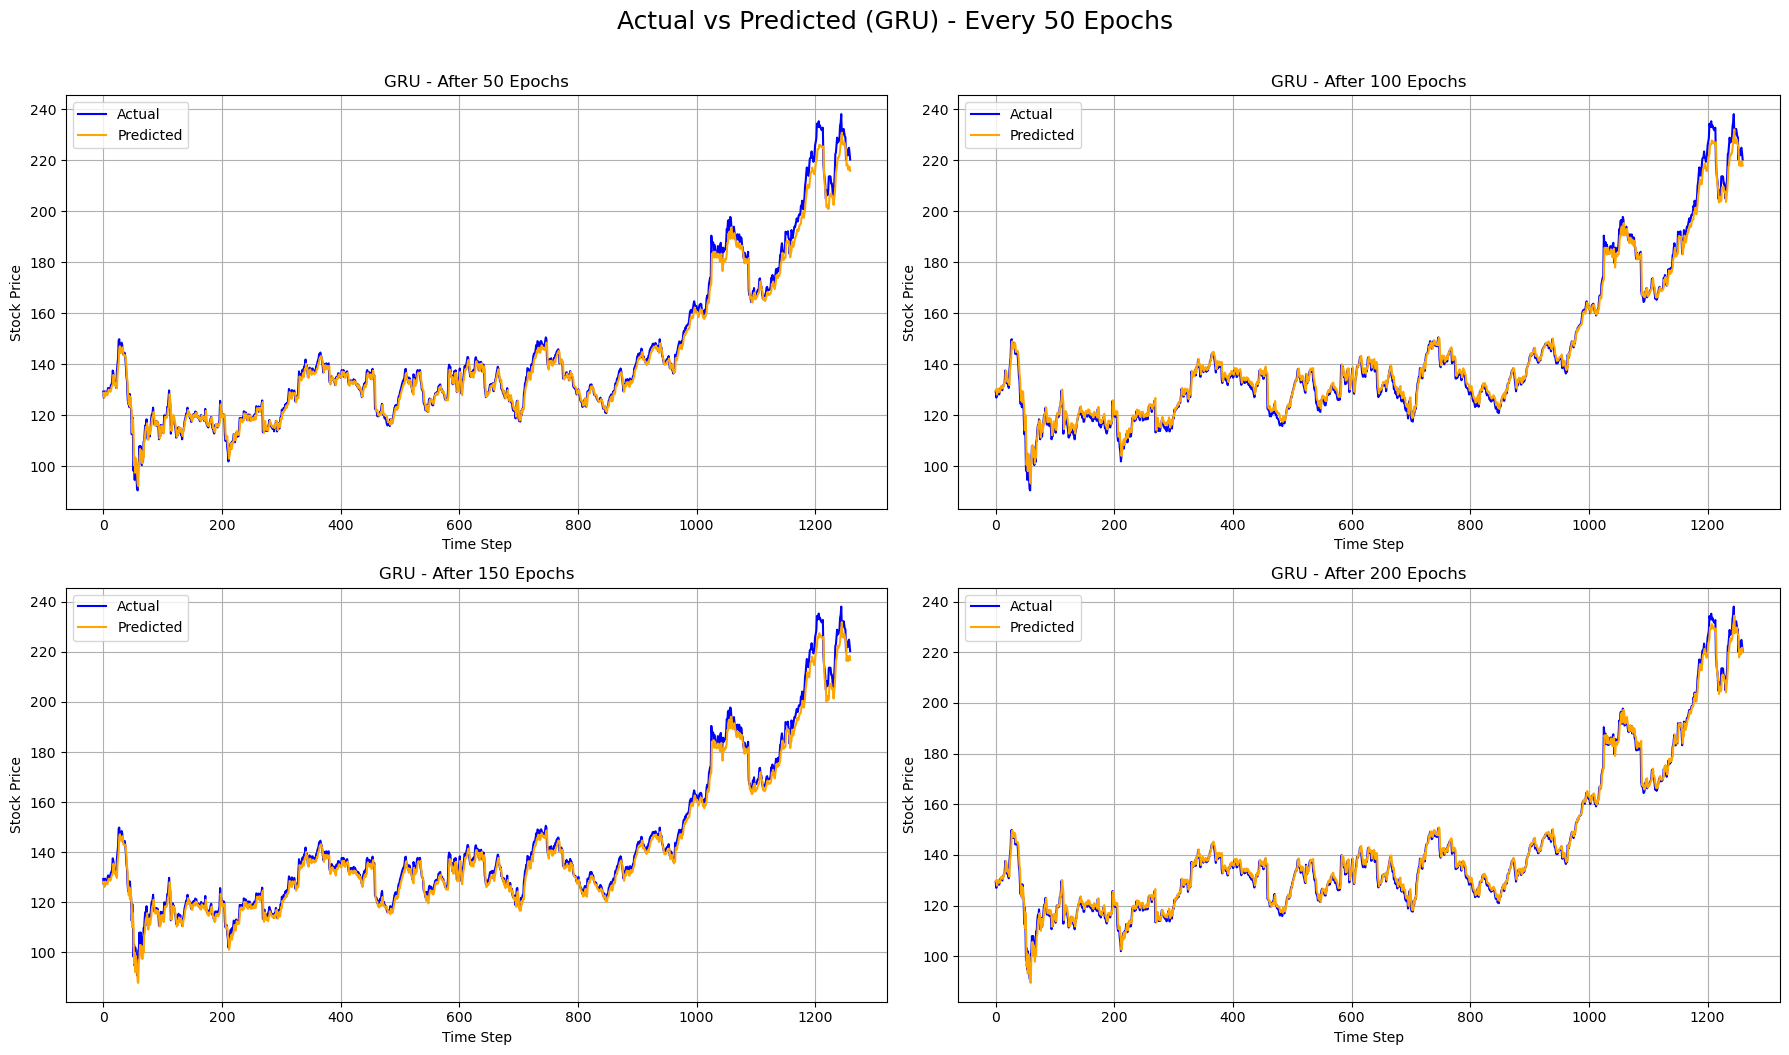

In [25]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSPE Calculation Function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# Correct GRU model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # First add Input layer
model.add(GRU(units=64, return_sequences=True))              # No input_shape here
model.add(Dropout(0.2))
model.add(GRU(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile with learning rate 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train + Plot for GRU
epochs_to_plot = [50, 100, 150, 200]
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()

total_epochs = 0

for i, e in enumerate(epochs_to_plot):
    epochs_to_train = 50 if i != 0 else e
    total_epochs += epochs_to_train

    print(f"\nTraining GRU up to {total_epochs} epochs...")

    model.fit(X_train, y_train, epochs=epochs_to_train, batch_size=64, verbose=0)

    y_pred = model.predict(X_test)

    # Inverse scaling (restore original scale of the target)
    zeros_test = np.zeros((y_test.shape[0], X_scaled.shape[1]))  # Adjust with X_scaled shape
    zeros_pred = np.zeros((y_pred.shape[0], X_scaled.shape[1]))  # Adjust with X_scaled shape

    # Inverse transform of actual and predicted values
    y_test_inv = scaler.inverse_transform(
        np.concatenate((zeros_test, y_test.reshape(-1, 1)), axis=1)
    )[:, -1]

    y_pred_inv = scaler.inverse_transform(
        np.concatenate((zeros_pred, y_pred), axis=1)
    )[:, -1]

    # Plot Actual vs Predicted
    axs[i].plot(y_test_inv, label='Actual', color='blue')
    axs[i].plot(y_pred_inv, label='Predicted', color='orange')
    axs[i].set_title(f'GRU - After {total_epochs} Epochs')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Stock Price')
    axs[i].legend()
    axs[i].grid(True)

    # Metrics calculation
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    rmspe_val = rmspe(y_test_inv, y_pred_inv)  # RMSPE calculation

    print(f"Evaluation after {total_epochs} epochs:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")
    print(f"  RMSPE: {rmspe_val:.4f}")  # Output RMSPE

# Layout adjustments
plt.tight_layout()
plt.suptitle("Actual vs Predicted (GRU) - Every 50 Epochs", fontsize=18, y=1.05)
plt.show()



Training Bidirectional GRU for 50 total epochs (adding 50 each step)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Metrics after 50 epochs:
RMSE: 3.2325
MAE : 2.4144
R²  : 0.9877
RMSPE: 0.0220

Training Bidirectional GRU for 100 total epochs (adding 50 each step)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Metrics after 100 epochs:
RMSE: 4.2615
MAE : 3.4692
R²  : 0.9787
RMSPE: 0.0281

Training Bidirectional GRU for 150 total epochs (adding 50 each step)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Metrics after 150 epochs:
RMSE: 2.7644
MAE : 2.0333
R²  : 0.9910
RMSPE: 0.0200

Training Bidirectional GRU for 200 total epochs (adding 50 each step)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Metrics after 200 epochs:
RMSE: 2.7774
MAE : 1.9923
R²  : 0.9909
RMSPE: 0.0195


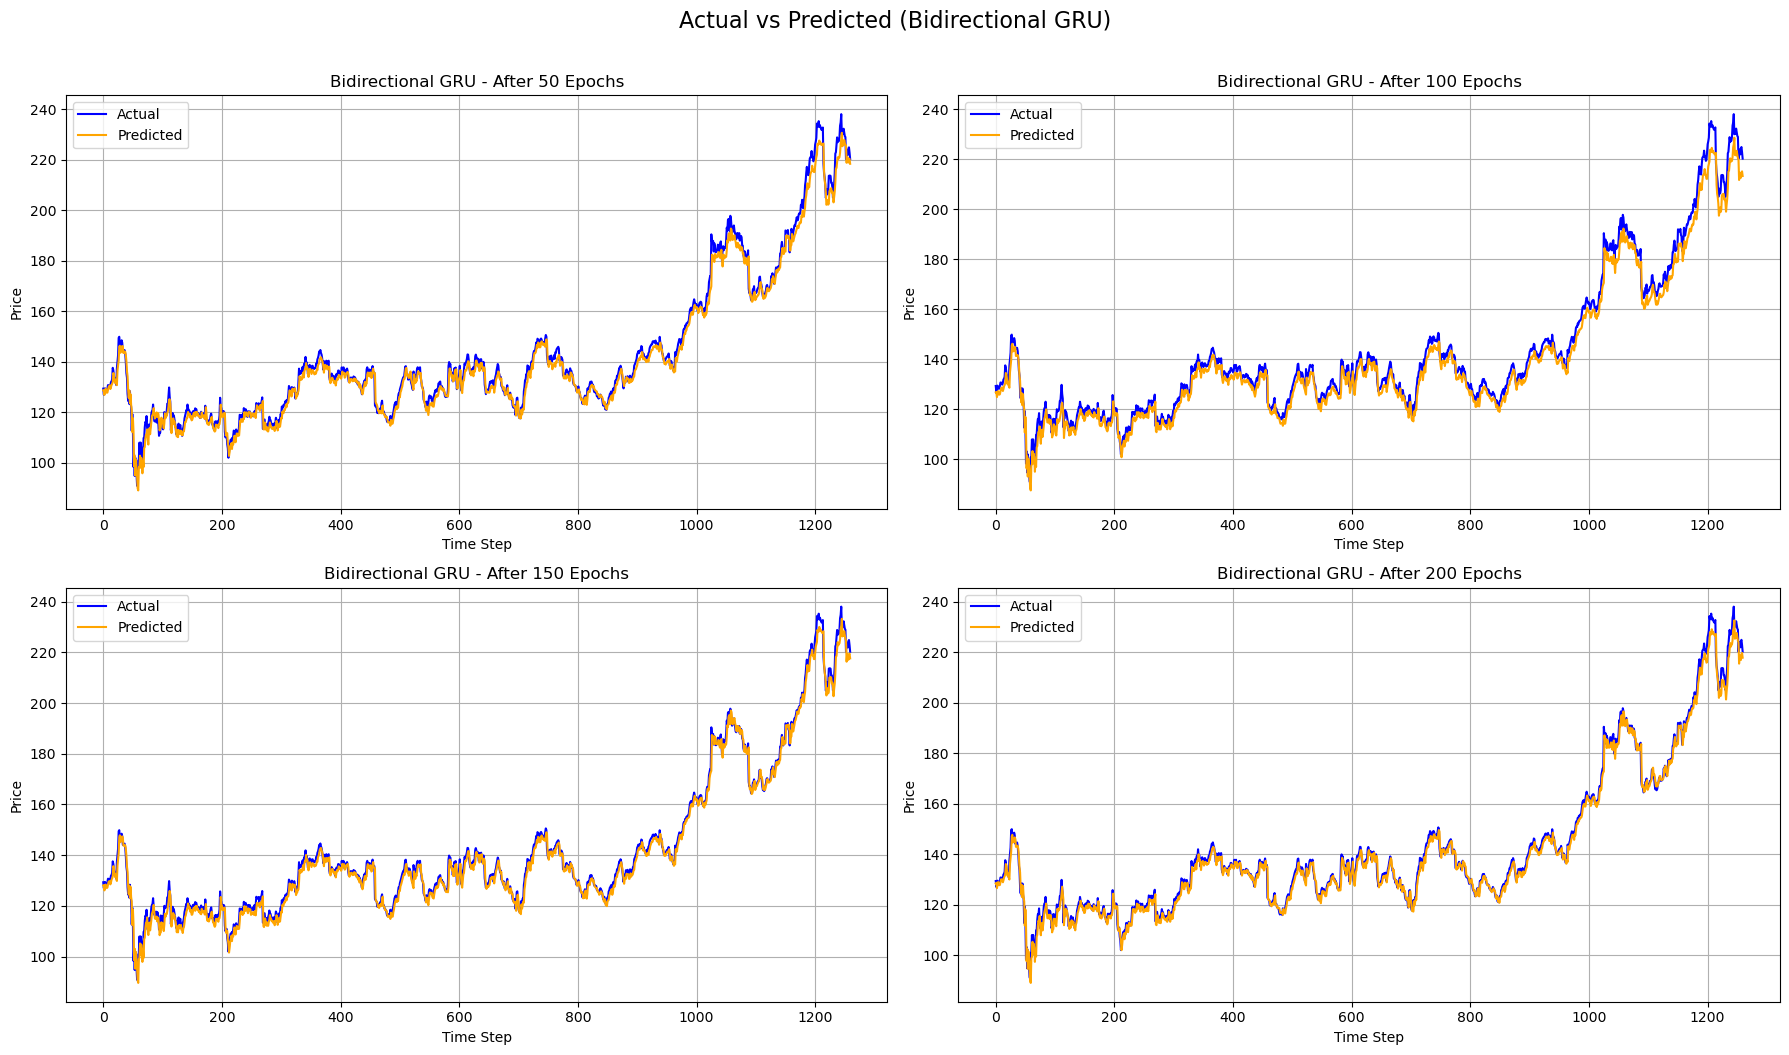

In [26]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSPE Calculation Function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# Bidirectional GRU Model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Explicit input layer
model.add(Bidirectional(GRU(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=32)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Epoch stages and subplot layout
epochs_to_plot = [50, 100, 150, 200]
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()

for i, e in enumerate(epochs_to_plot):
    print(f"\nTraining Bidirectional GRU for {e} total epochs (adding 50 each step)...")
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0)

    # Predict
    y_pred = model.predict(X_test)

    # Inverse scale only the target
    y_test_inv = scaler.inverse_transform(
        np.concatenate((np.zeros((y_test.shape[0], X_scaled.shape[1])), y_test.reshape(-1, 1)), axis=1)
    )[:, -1]

    y_pred_inv = scaler.inverse_transform(
        np.concatenate((np.zeros((y_pred.shape[0], X_scaled.shape[1])), y_pred), axis=1)
    )[:, -1]

    # Plot
    axs[i].plot(y_test_inv, label='Actual', color='blue')
    axs[i].plot(y_pred_inv, label='Predicted', color='orange')
    axs[i].set_title(f'Bidirectional GRU - After {e} Epochs')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Price')
    axs[i].legend()
    axs[i].grid(True)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    rmspe_val = rmspe(y_test_inv, y_pred_inv)  # RMSPE calculation

    print(f"Metrics after {e} epochs:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print(f"RMSPE: {rmspe_val:.4f}")  # Output RMSPE

# Final layout
plt.tight_layout()
plt.suptitle("Actual vs Predicted (Bidirectional GRU)", fontsize=16, y=1.05)
plt.show()
